# Zero2API Client

## Overview


We show data access (query) against an open data table on AWS: Positions every 2 seconds for 
a congress of 26 cooperatives baboons (wearing GPS collars) at the Amboseli National Park, Kenya. 
The data covers one day. We present two access paths: Basic table rows and a 'dispersion/speed'
service.


The basic API returns sub-tables with four columns: individual **ID**, **time**, and then **x** and **y**
coordinates.


The second 'dispersion/speed' API makes use of the basic API as its data source. We call this *API composition*.
The rationale for not simply adding complexity to the first API is to encourage software modularity. 


### Basic API examples

The basic query is constructed as a *string* that begins with a base URL, the location of the service
which is hosted on the Amazon cloud. Appended to this are four values: A key to which individual baboon, 
a time range as 'time0' and then 'time1', and a flag indicating whether to return the results as HTML 
or as JSON. 

In [2]:
# use the 'baboons1' interface to get 11 rows of data
import pandas as pd

indiv   = 10                      # From (at least) 38 GPS we have data from 26. This selects indiv '10'
table   = 'false'                 # tabular data flag false means 'return JSON'
t0, t1  = '9:00:00', '9:00:22'    # short time interval, 9am local time      

baseURL = 'https://rlu4ch9a57.execute-api.us-west-2.amazonaws.com/default/baboon1'
url     = baseURL + '?indiv={}&table={}&t0={}&t1={}'.format(indiv,table,t0,t1)
a=pd.read_json(url)               # this is the API call; 'url' includes query details
a                                 # response is a pandas DataFrame with 12 rows of data

,indiv,time,x,y
0,10,9:00:00,300.463922,-405.358183
1,10,9:00:02,299.873931,-405.413842
2,10,9:00:04,299.228279,-405.658740
3,10,9:00:06,298.849794,-406.204193
4,10,9:00:08,298.827531,-406.794174
5,10,9:00:10,298.916586,-407.206047
6,10,9:00:12,298.916586,-407.339628
7,10,9:00:14,298.894322,-407.350760
8,10,9:00:16,298.894322,-407.395286
9,10,9:00:18,298.827531,-407.617921


In [3]:
# Illustrates pandas DataFrame attributes

print(type(a), '\n\n', a, '\n\n', a.index, '\n\n', a.columns, '\n\n', a['time'], '\n\n', a['x'][0:3])

<class 'pandas.core.frame.DataFrame'> 

     indiv     time           x           y
0      10  9:00:00  300.463922 -405.358183
1      10  9:00:02  299.873931 -405.413842
2      10  9:00:04  299.228279 -405.658740
3      10  9:00:06  298.849794 -406.204193
4      10  9:00:08  298.827531 -406.794174
5      10  9:00:10  298.916586 -407.206047
6      10  9:00:12  298.916586 -407.339628
7      10  9:00:14  298.894322 -407.350760
8      10  9:00:16  298.894322 -407.395286
9      10  9:00:18  298.827531 -407.617921
10     10  9:00:20  298.571497 -407.996399
11     10  9:00:22  298.226407 -408.274691 

 RangeIndex(start=0, stop=12, step=1) 

 Index(['indiv', 'time', 'x', 'y'], dtype='object') 

 0     9:00:00
1     9:00:02
2     9:00:04
3     9:00:06
4     9:00:08
5     9:00:10
6     9:00:12
7     9:00:14
8     9:00:16
9     9:00:18
10    9:00:20
11    9:00:22
Name: time, dtype: object 

 0    300.463922
1    299.873931
2    299.228279
Name: x, dtype: float64


In [4]:
%%time

# test the interface: try out various query formats including a bounding box version

indiv = 10
table = 'false'
t0 = '20:59:52'
t1 = '21:00:12'
x0 = -770.
x1 = -780.
y0 =  430.
y1 =  420.

# full scan
# url = baseURL + '?indiv={}&table={}&t0={}&t1={}&x0={}&x1={}&y0={}&y1={}'.format(indiv,table,t0,t1,x0,x1,y1,y0)

# scan sans indiv
# url = baseURL + '?table={}&t0={}&t1={}&x0={}&x1={}&y0={}&y1={}'.format(table,t0,t1,x0,x1,y1,y0)

# query indiv and time: Working
url = baseURL + '?indiv={}&table={}&t0={}&t1={}'.format(indiv,table,t0,t1)

# url = baseURL + '?table={}&t0={}&t1={}'.format(table,t0,t1)
# url = baseURL + '?indiv={}&table={}'.format(indiv,table)

a=pd.read_json(url)
print(url, '\n\n', a)

https://rlu4ch9a57.execute-api.us-west-2.amazonaws.com/default/baboon1?indiv=10&table=false&t0=20:59:52&t1=21:00:12 

     indiv      time          x           y
0      10  20:59:52  89.970546  330.581426
1      10  20:59:54  90.081865  330.681612
2      10  20:59:56  90.148657  330.781797
3      10  20:59:58  90.037338  330.815192
4      10  21:00:00  89.825831  330.870851
5      10  21:00:02  89.647721  330.926509
6      10  21:00:04  89.525270  330.870851
7      10  21:00:06  89.358291  330.804060
8      10  21:00:08  89.146785  330.726138
9      10  21:00:10  88.935278  330.692743
10     10  21:00:12  88.679244  330.570294
CPU times: user 19.5 ms, sys: 871 µs, total: 20.4 ms
Wall time: 366 ms


### Composition API examples

The API used above uses a URL `etcetc.execute-api.us-west-2.amazonaws.com` with API query parameters 
appended to pull data from the DynamoDB tablewhereas below
this changes to flag

In [9]:
# obtain one moment of inertia value for the entire troupe using one minute of data
import requests

urlcomp = 'https://ycg3xmhjwj.execute-api.us-west-2.amazonaws.com/default/babooncomposition'
t0 = '17:20:00'                        # t0 - t1 defines a first time interval
t1 = '17:21:00'                        # t2 - t3 defines another (in this case adjacent) time interval
t2 = '17:21:00'
t3 = '17:22:00'
url= urlcomp + '?t0={}&t1={}&t2={}&t3={}'.format(t0,t1,t2,t3)
a = requests.get(url)
print(a.content.decode('utf-8'))       # typically requires about 20 seconds
                                       # returns five values: 
                                       #   dispersion(t0-t1), 
                                       #   dispersion(t2-t3),
                                       #   number of data values (t0-t1),
                                       #   number of data values (t2-t3),
                                       #   change in location (meters, center of mass, (t0-t1) to (t2-t3))

33.8435671737139,33.087750806186904,744,744,4.101875664798991


In [10]:
# test a bad query (the times are incorrectly formatted)
#   this should result in a fail indication
import requests
urlcomp = 'https://ycg3xmhjwj.execute-api.us-west-2.amazonaws.com/default/babooncomposition'
t0, t1, t2, t3 = 'a', 'b', 'c', 'd'
url = urlcomp + '?t0={}&t1={}&t2={}&t3={}'.format(t0,t1,t2,t3)
a   = requests.get(url)
print(a.content.decode('utf-8'))       # typically requires about 20 seconds

0.0,0.0,0,0,0.0


In [15]:
# obtain one moment of inertia value for the entire troupe using one minute of data
import requests
urlcomp = 'https://ycg3xmhjwj.execute-api.us-west-2.amazonaws.com/default/babooncomposition'
t0 = '9:00:00'       # notice these do not begin with '09' but rather just '9'
t1 = '9:05:00'
t2 = '9:05:00'
t3 = '9:10:00'

url= urlcomp + '?t0={}&t1={}&t2={}&t3={}'.format(t0,t1,t2,t3)
a = requests.get(url)
print(a.content.decode('utf-8'))

20.811275339470505,18.244949592575576,3775,3775,23.430055070594733


In [16]:
print(url)

https://ycg3xmhjwj.execute-api.us-west-2.amazonaws.com/default/babooncomposition?t0=9:00:00&t1=9:05:00&t2=9:05:00&t3=9:10:00


In [17]:
%%time

# run a full day of queries on dispersion and speed
import requests

def TimeBuilder():
    # Hour string begins '7', not '07' etc for single-digit hours
    nHours = 24
    t = []
    for i in range(nHours):
        for j in range(6):
            hrstring = str(i)
            jj = j * 10
            if jj == 0: minstring = '00'
            else:       minstring = str(jj)
            jjj = jj + 5
            if jjj == 5: minstring1 = '05'
            else:        minstring1 = str(jjj)

            t0 = hrstring + ':' + minstring + ':00'
            t1 = hrstring + ':' + minstring1 + ':00'
            t2 = hrstring + ':' + minstring1 + ':00'
            
            jjjj = jjj + 5
            if jjjj < 60: t3 = hrstring + ':' + str(jjjj) + ':00'
            else:         t3 = hrstring + ':59:59'

            t.append((t0,t1,t2,t3))     # a tuple of four strings               
    return t

t = TimeBuilder()
urlcomp = 'https://ycg3xmhjwj.execute-api.us-west-2.amazonaws.com/default/babooncomposition'
myresults = []
for time in t:
    url= urlcomp + '?t0={}&t1={}&t2={}&t3={}'.format(time[0],time[1],time[2],time[3])
    myresults.append(requests.get(url).content.decode("utf-8").split(','))
    print('finished', time[0], time[1], time[2], time[3])
    
with open('speed_test_moimoispeed_5min_1day.txt', 'w') as f:
    for item in myresults: f.write("%s\n" % item)
        
print(myresults)

finished 0:00:00 0:05:00 0:05:00 0:10:00
finished 0:10:00 0:15:00 0:15:00 0:20:00
finished 0:20:00 0:25:00 0:25:00 0:30:00
finished 0:30:00 0:35:00 0:35:00 0:40:00
finished 0:40:00 0:45:00 0:45:00 0:50:00
finished 0:50:00 0:55:00 0:55:00 0:59:59
finished 1:00:00 1:05:00 1:05:00 1:10:00
finished 1:10:00 1:15:00 1:15:00 1:20:00
finished 1:20:00 1:25:00 1:25:00 1:30:00
finished 1:30:00 1:35:00 1:35:00 1:40:00
finished 1:40:00 1:45:00 1:45:00 1:50:00
finished 1:50:00 1:55:00 1:55:00 1:59:59
finished 2:00:00 2:05:00 2:05:00 2:10:00
finished 2:10:00 2:15:00 2:15:00 2:20:00
finished 2:20:00 2:25:00 2:25:00 2:30:00
finished 2:30:00 2:35:00 2:35:00 2:40:00
finished 2:40:00 2:45:00 2:45:00 2:50:00
finished 2:50:00 2:55:00 2:55:00 2:59:59
finished 3:00:00 3:05:00 3:05:00 3:10:00
finished 3:10:00 3:15:00 3:15:00 3:20:00
finished 3:20:00 3:25:00 3:25:00 3:30:00
finished 3:30:00 3:35:00 3:35:00 3:40:00
finished 3:40:00 3:45:00 3:45:00 3:50:00
finished 3:50:00 3:55:00 3:55:00 3:59:59
finished 4:00:00

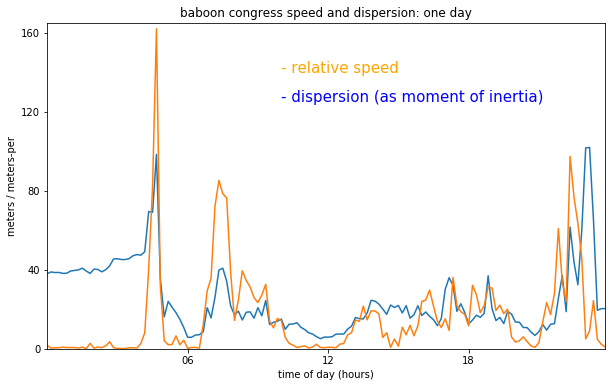

In [18]:
# file 'moimoispeed_5min_1day.txt' was generated by the previous cell. The data are loaded
#   in this cell and presented on a chart

%matplotlib inline
import matplotlib.pyplot as plt
import datetime
from matplotlib import dates as mdates
from numpy import datetime64 as dt64
import csv

with open('moimoispeed_5min_1day.txt') as csv_file:
    csv_reader, m, s = csv.reader(csv_file, delimiter=','), [], []
    for row in csv_reader:
        m.append(float(row[0].split("'")[1]))
        s.append(float(row[4].split("'")[1]))

times = [dt64(j, 'm') for j in range(0, 24*60,10)]       

tFmt, t0, t1, tticks = mdates.DateFormatter("%H"), times[0], times[143], [times[36], times[72], times[108]]

p,a = plt.subplots(figsize=(10,6))
a.plot(times, m)
a.plot(times, s)
a.set(xlim=(t0, t1), xticks=tticks, ylim=(0, 165.), yticks=[0., 40.,80.,120.,160.])
a.xaxis.set_major_formatter(tFmt)
a.text(times[60], 140., '- relative speed',                    rotation=0, fontsize=15, color='orange', fontweight='normal')
a.text(times[60], 125., '- dispersion (as moment of inertia)', rotation=0, fontsize=15, color='blue', fontweight='normal')
a.set_xlabel('time of day (hours)')
a.set_ylabel('meters / meters-per')
a.set(title='baboon congress speed and dispersion: one day')
print('')   

In [19]:
print(sum(s))

2390.7291746939372
